In [1]:
import numpy as np
import pandas as pd
import random
import pickle
import math
import copy
random.seed = 456

In [2]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

In [3]:
from matplotlib import pyplot as plt

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV

In [5]:
def tf(list_keywords):
    res = []
    for keywords in list_keywords:
        sum_val = sum(keywords.values())
        keywords = keywords.copy()
        for word in keywords:
            keywords[word] /= sum_val
        res.append(keywords)
    return res


def tfidf(list_keywords):
    idf = dict.fromkeys(list_keywords[0].keys(), 0.0)

    for keywords in list_keywords:
        for word, _ in filter(lambda x: x[1] > 0, keywords.items()):
            idf[word] += 1.0

    for word in idf:
        if idf[word]:
            idf[word] = math.log(len(list_keywords) / idf[word])

    res = []
    for keywords in list_keywords:
        keywords = keywords.copy()
        s = sum(keywords.values())
        for word, _ in filter(lambda x: x[1] > 0, keywords.items()):
            keywords[word] *= idf[word] / s
        res.append(keywords)
    return res


def tfc(list_keywords):
    list_keywords = tfidf(list_keywords)
    keywords = list_keywords[0].keys()
    res_list = []
    for i, val in enumerate(list_keywords):
        norm = 0
        for v in val.values():
            norm += v**2
        norm = math.sqrt(norm)
        #norm = length_vector(val.values())

        if norm == 0:
            res_list.append(dict(zip(keywords, val.values())))
            continue
        res = map(lambda x: x / norm, val.values())
        res_list.append(dict(zip(keywords, res)))

    return res_list

In [6]:
def word_cloud(word_bag, name, ax=None):

    wc = WordCloud(background_color="white", height=500, width=1000,random_state=random.seed)
    wc.generate_from_frequencies(word_bag)
    if ax is not None:
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(name)
        ax.axis(False)
    else:
        plt.subplots(num=None, figsize=(15, 10), dpi=80)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(name)
        plt.axis("off")

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stemmer = SnowballStemmer(language='english')
word_net_lem = nltk.WordNetLemmatizer()
set_stopwords = set(stopwords.words('english'))
set_punctuation = string.punctuation

In [9]:
set_punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def preproc_stem_nltk(text):
    tokens = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in tokens if word not in set_stopwords and word not in set_punctuation]

In [11]:
def preproc_lemm_nltk(text):
    tokens = word_tokenize(text.lower())
    return [word_net_lem.lemmatize(word) for word in tokens if word not in set_stopwords and word not in set_punctuation]

In [12]:
def total_bag(results):
    dict_words = dict()
    for result in results:
        tokens = preproc_lemm_nltk(result['abstract'])
        for token in tokens:
            if token not in dict_words:
                dict_words[token] = 1
            else:
                dict_words[token] += 1
    return dict_words

In [13]:
def bag_article(abstract,bag):
    tokens = preproc_lemm_nltk(abstract)
    for token in tokens:
        if token in bag:
            bag[token] += 1
    return bag

In [14]:
def cut_low_freq_words(bag_words,number=0):       
    temp_dict = dict()
    for word in bag_words:
        if bag_words[word] > number:
            temp_dict[word] = bag_words[word]
    return temp_dict

In [15]:
def make_list_keywords(bag_words,results):       
    list_keywords = []
    temp_bag = dict.fromkeys(bag_words, 0)
    for result in results:
        list_keywords.append(bag_article(result['abstract'],temp_bag.copy()))
    del temp_bag
    return list_keywords

In [16]:
def make_list_keywords_weight_items(list_keywords_weight):       
    list_keywords_weight_items = []
    for item in list_keywords_weight:
        list_keywords_weight_items.append(list(item.values()))
    return list_keywords_weight_items

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def precision_binary_pos_func(y_true, y_pred):
    return precision_score(y_true, y_pred,pos_label=0)
def recall_binary_pos_func(y_true, y_pred):
    return recall_score(y_true, y_pred,pos_label=0)
def f1_binary_pos_func(y_true, y_pred):
    return recall_score(y_true, y_pred,pos_label=0)

In [18]:
from sklearn.metrics import make_scorer
precision_binary_pos = make_scorer(precision_binary_pos_func, greater_is_better=True)
recall_binary_pos = make_scorer(recall_binary_pos_func, greater_is_better=True)
f1_binary_pos = make_scorer(f1_binary_pos_func, greater_is_better=True)
def classifier_scores(model, x_train, y_train, x_test=None, y_test=None):
    cv = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    scores = cross_validate(model,X_train,y_train,cv=cv,return_estimator=True,scoring={'accuracy':'accuracy', 'precision_binary_pos':precision_binary_pos, 'recall_binary_pos':recall_binary_pos, 'f1_binary_pos':f1_binary_pos})
    return cv, scores

In [19]:
def classifier_plot(list_cv,list_scores, x_train, y_train, x_test=None,y_test=None):

    list_num_best_models = []
    for i in range(len(list_scores)):
        list_num_best_models.append(list_scores[i]['test_f1_binary_pos'].argmax())

    models =[]
    for i in range(len(list_scores)):
        models.append(list_scores[i]['estimator'][list_num_best_models[i]])
    
    list_x_test = []
    list_y_test = []
    for j in range(len(list_num_best_models)):
        if x_test is None and y_test is None:
            _, test_num = list(list_cv[j].split(x_train,y_train))[list_num_best_models[j]]
            x_test, y_test = [], []
            for i in test_num:
                x_test.append(x_train[i])
                y_test.append(y_train[i])
            list_x_test.append(x_test)
            list_y_test.append(y_test)
            x_test = None
            y_test = None

    list_y_proba = []
    for i in range(len(models)):
        list_y_proba.append(models[i].predict_proba(list_x_test[i])[:,1])
    
    list_fpr = [0] * len(list_y_proba)
    list_tpr = [0] * len(list_y_proba)
    for i in range(len(list_y_proba)):
        list_fpr[i], list_tpr[i], _ = roc_curve(list_y_test[i], list_y_proba[i])

    #name = f'{str(model).split("(")[0]}\nAUC = {round(roc_auc_score(list_y_test[i], y_proba),5)}'
    plt.figure(figsize=(15,10))
    lw = 2
    for i in range(len(list_tpr)):
        plt.plot(
            list_fpr[i],
            list_tpr[i],
            #color="darkorange",
            lw=lw,
            label=f'{str(models[i]).split("(")[0]}\nAUC = {round(roc_auc_score(list_y_test[i], list_y_proba[i]),5)}'
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.title(name)
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

#### Формирование выборки

In [19]:
with open('after_results_iad3.pkl','rb') as ar:
    pre_results_iad = pickle.load(ar)

In [20]:
len(pre_results_iad)

2000

In [21]:
data_pre_iad = pd.DataFrame(pre_results_iad)

In [22]:
sum(data_pre_iad.link.value_counts() == 2)

85

In [23]:
pre_results_iad[0]

{'title': 'Text mining for incoming tasks based on the urgency/importance factors and task classification using machine learning tools',
 'link': 'https://dl.acm.org/doi/10.1145/3388142.3388153',
 'authors': ['Yasser Ali Alshehri'],
 'date': 'March 2020',
 'abstract': 'In workplaces, there is a massive amount of unstructured data from different sources. In this paper, we present a case study that explains how can through communications between employees, we can help to prioritize tasks requests to increase the efficiency of their works for both technical and non-technical workers. This involves managing daily incoming tasks based on their level of urgency and importance.To allow all workers to utilize the urgency-importance matrix as a time-management tool, we need to automate this tool. The textual content of incoming tasks are analyzed, and metrics related to urgency and importance are extracted. A third factor (i.e., the response variable) is defined based on the two input variables

In [24]:
#results_no_iad = []
#for t in ['cs','db','fl','hw','se','sm']:
    #with open(f'after_results_{t}.pkl','rb') as ar:
        #res = pickle.load(ar)
        #for r in res:
            #r['label']=t
        #results_no_iad += res

In [25]:
with open('after_results_no_iad.pkl','rb') as ar:
    pre_results_no_iad = pickle.load(ar)

In [26]:
len(pre_results_no_iad)

2400

In [27]:
data_pre_no_iad = pd.DataFrame(pre_results_no_iad)

In [28]:
sum(data_pre_no_iad.link.value_counts() == 2) # 9 - 3, 161 - 2

161

In [29]:
pre_results_no_iad[0]

{'title': 'A Research on Problems and Countermeasures of Computer Network Security in the Era of Big Data',
 'link': 'https://dl.acm.org/doi/10.1145/3472349.3472354',
 'authors': ['Zhang Yuling'],
 'date': 'May 2021',
 'abstract': 'In the era of big data, the speed of information dissemination is accelerating and the amount of data is increasing. People in all corners of the world can quickly share information through the network, and the computer network has become an information superhighway for various applications. However, science and technology is a double-edged sword. Computer networks are facing security problems such as hacker attacks, virus intrusion and information leakage. In order to provide users with a safe network environment, this paper analyzes the security problems and security protection strategies of computer networks, and takes the network construction of colleges and universities as an example, puts forward the design of the network security system of colleges an

In [ ]:
results_links = []

In [31]:
results_iad = []
results_iad_links = []
while len(results_iad) != 1500:
    res = [pre_results_iad[random.randint(0,len(pre_results_iad)-1)]]
    if res[0]['link'] not in results_iad_links:
        results_iad_links.append(res[0]['link'])
        if len(res[0]['abstract']) != 0:
            results_iad += res
    else:
        pass

In [32]:
len(results_iad)

1500

In [33]:
results_links = copy.deepcopy(results_iad_links)

In [46]:
results_no_iad = []
results_no_iad_links = []
while len(results_no_iad) != 1500:
    res = [pre_results_no_iad[random.randint(0,len(pre_results_no_iad)-1)]]
    if res[0]['link'] not in results_no_iad_links and res[0]['link'] not in results_links:
        results_no_iad_links.append(res[0]['link'])
        if len(res[0]['abstract']) != 0:
            results_no_iad += res
    else:
        pass

In [47]:
len(results_no_iad)

1500

In [76]:
pd.DataFrame(results_no_iad).label.value_counts()/len(results_no_iad)

se    0.168667
sm    0.168000
hw    0.167333
db    0.166000
cs    0.166000
fl    0.164000
Name: label, dtype: float64

In [49]:
#with open('results_iad.pkl','wb') as pr:
    #pickle.dump(results_iad,pr)

In [50]:
#with open('results_no_iad.pkl','wb') as pr:
    #pickle.dump(results_no_iad,pr)

#### Окончание формирования выборки

In [20]:
with open('results_iad.pkl','rb') as ar: # results_iad_old (with repeat)
    results_iad = pickle.load(ar)

In [21]:
with open('results_no_iad.pkl','rb') as ar: # results_no_iad_old (with repeat)
    results_no_iad = pickle.load(ar)

In [22]:
results_iad[0]

{'title': 'Heavy hitters via cluster-preserving clustering',
 'link': 'https://dl.acm.org/doi/10.1145/3339185',
 'authors': ['Kasper Green Larsen',
  'Jelani Nelson',
  'Huy L. Nguyễn',
  'Mikkel Thorup'],
 'date': 'August 2019',
 'abstract': 'We develop a new algorithm for the turnstile heavy hitters problem in general turnstile streams, the EXPANDERSKETCH, which finds the approximate top-k items in a universe of size n using the same asymptotic O(k log n) words of memory and O(log n) update time as the COUNTMIN and COUNTSKETCH, but requiring only O(k poly(log n)) time to answer queries instead of the O(n log n) time of the other two. The notion of "approximation" is the same l2 sense as the COUNTSKETCH, which given known lower bounds is the strongest guarantee one can achieve in sublinear memory.Our main innovation is an efficient reduction from the heavy hitters problem to a clustering problem in which each heavy hitter is encoded as some form of noisy spectral cluster in a graph, a

In [24]:
results_no_iad[0]

{'title': 'ByShard: sharding in a byzantine environment',
 'link': 'https://dl.acm.org/doi/10.14778/3476249.3476275',
 'authors': ['Jelle Hellings', 'Mohammad Sadoghi'],
 'date': 'July 2021',
 'abstract': 'he emergence of blockchains has fueled the development of resilient systems that can deal with Byzantine failures due to crashes, bugs, or even malicious behavior. Recently, we have also seen the exploration of sharding in these resilient systems, this to provide the scalability required by very large data-based applications. Unfortunately, current sharded resilient systems all use system-specific specialized approaches toward sharding that do not provide the flexibility of traditional sharded data management systems.To improve on this situation, we fundamentally look at the design of sharded resilient systems. We do so by introducing BYSHARD, a unifying framework for the study of sharded resilient systems. Within this framework, we show how two-phase commit and two-phase locking---t

In [25]:
len(results_iad)

1500

In [26]:
len(results_no_iad)

1500

In [27]:
results = results_iad + results_no_iad

In [28]:
data_iad = pd.DataFrame(results_iad)

In [29]:
sum(data_iad.link.value_counts() == 1) # 60 - 2

1500

In [30]:
data_no_iad = pd.DataFrame(results_no_iad)

In [31]:
sum(data_no_iad.link.value_counts() == 1) # 8 - 5, 19 - 4, 78 - 3, 301 - 2

1500

In [32]:
data = pd.DataFrame(results)

In [33]:
sum(data.link.value_counts() == 1) # 8 - 5, 22 - 4, 79 - 3, 362 - 2

3000

In [34]:
bag_words_iad = total_bag(results_iad)

In [35]:
bag_words_no_iad = total_bag(results_no_iad)

In [36]:
bag_words_begin = total_bag(results)

In [37]:
series_words_iad = pd.Series(bag_words_iad,index = bag_words_iad.keys())

In [38]:
series_words_no_iad = pd.Series(bag_words_no_iad,index = bag_words_no_iad.keys())

In [39]:
series_words = pd.Series(bag_words_begin,index = bag_words_begin.keys())

In [40]:
sum(series_words == 1)

10291

In [41]:
len(series_words_iad)

13106

In [42]:
len(series_words_no_iad)

15958

In [43]:
len(series_words)

22361

In [44]:
series_words.sort_values(ascending=False)/len(series_words)

data             0.201601
model            0.114843
system           0.113904
learning         0.101605
method           0.100756
                   ...   
kinetics-400     0.000045
activitynet      0.000045
keying           0.000045
up-conversion    0.000045
f7               0.000045
Length: 22361, dtype: float64

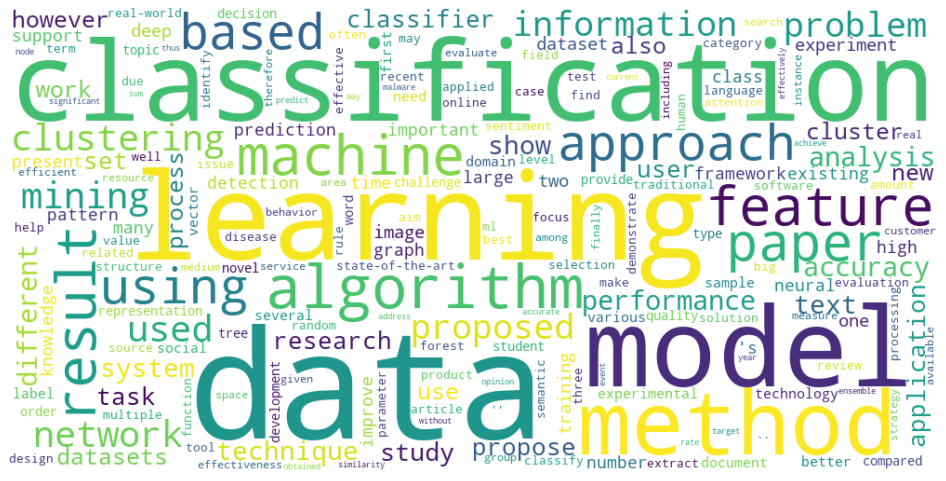

In [45]:
word_cloud(bag_words_iad,'') # 'TOTAL BAG PRE IAD'

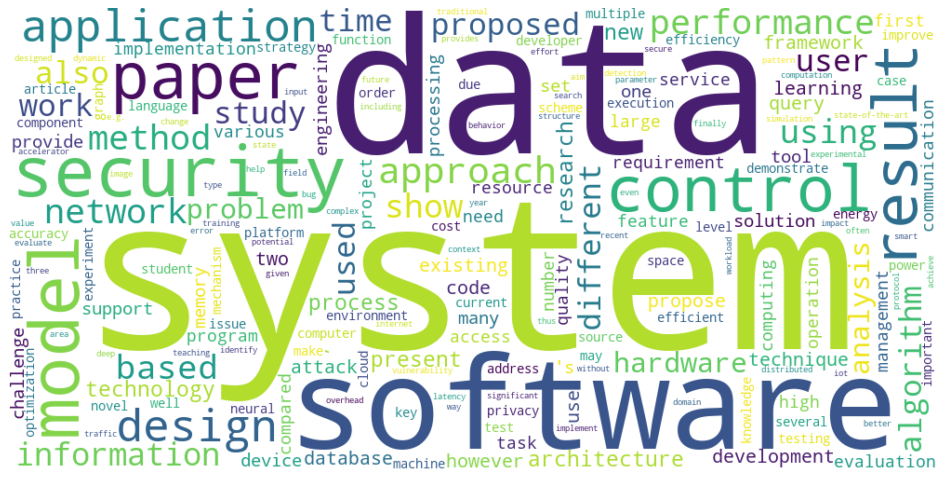

In [46]:
word_cloud(bag_words_no_iad,'') # 'TOTAL BAG PRE NO IAD'

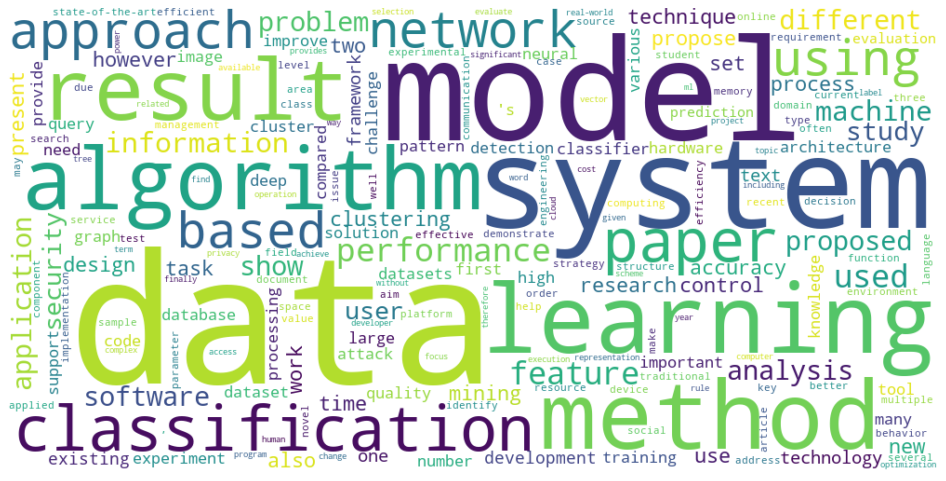

In [47]:
word_cloud(bag_words_begin,'') # 'TOTAL BAG PRE'

#### BAG ARTICLE

In [48]:
bag_words=cut_low_freq_words(bag_words_begin,number=1)

In [49]:
list_keywords=make_list_keywords(bag_words,results)

In [50]:
list_keywords_weight = tfc(list_keywords)

In [51]:
list_keywords_weight_items = make_list_keywords_weight_items(list_keywords_weight)

In [52]:
array_keywords_weight_items = np.array(list_keywords_weight_items)

In [77]:
pca2 = PCA(n_components=2)
pca_keywords2 = pca2.fit_transform(array_keywords_weight_items)

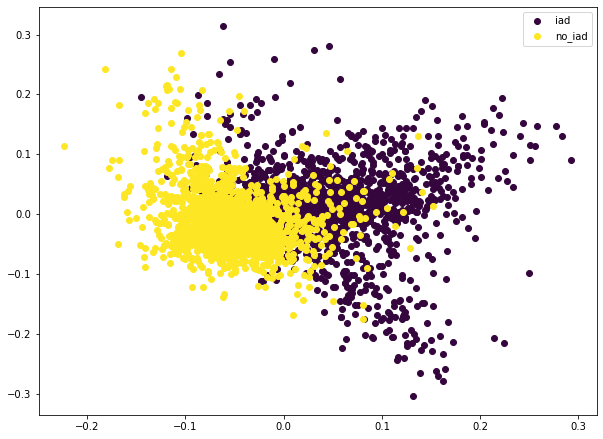

In [78]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(pca_keywords2[:1500,0],pca_keywords2[:1500,1],label='iad',c='xkcd:dark purple')
plt.scatter(pca_keywords2[1500:,0],pca_keywords2[1500:,1],label='no_iad',c='#fde725')
plt.legend()
plt.show()

In [54]:
pca3 = PCA(n_components=3)
pca_keywords3 = pca3.fit_transform(array_keywords_weight_items)

In [55]:
%matplotlib notebook

<IPython.core.display.Javascript object>


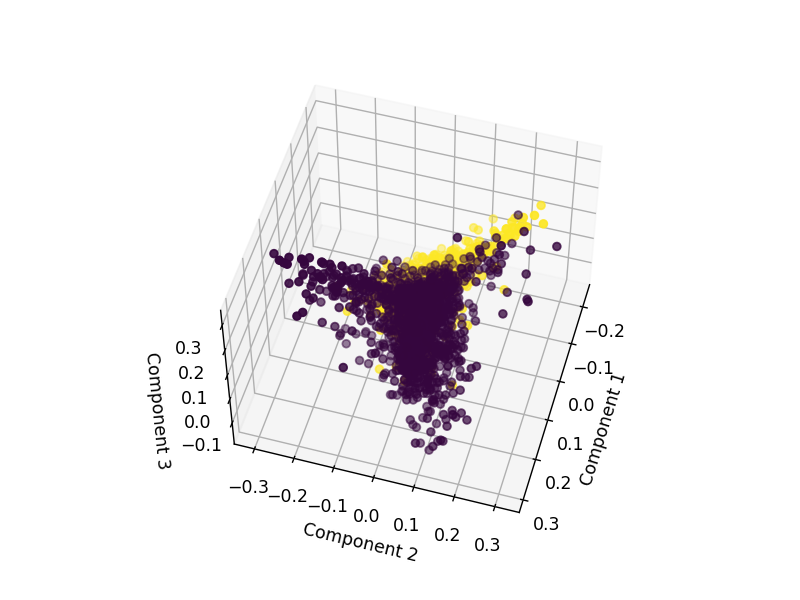

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_keywords3[:1500,0],pca_keywords3[:1500,1],pca_keywords3[:1500,2],label='iad',c='xkcd:dark purple')
ax.scatter(pca_keywords3[1500:,0],pca_keywords3[1500:,1],pca_keywords3[1500:,2],label='no_iad',c='#fde725')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.show()

In [57]:
%matplotlib inline

In [55]:
tsne = TSNE(n_components=2)
tsne_keywords = tsne.fit_transform(array_keywords_weight_items)

C:\Programs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Programs\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


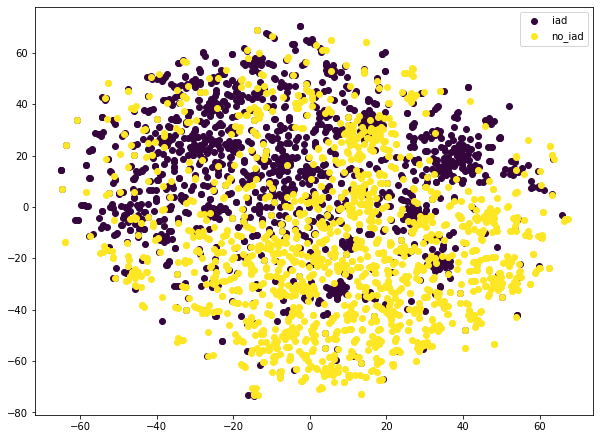

In [64]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(tsne_keywords[:1500,0],tsne_keywords[:1500,1],label='iad',c='xkcd:dark purple')
plt.scatter(tsne_keywords[1500:,0],tsne_keywords[1500:,1],label='no_iad',c='#fde725')
plt.legend()

In [65]:
list_values = list_keywords_weight[0]
for i in range(1,len(list_keywords_weight)):
    for key in list_keywords_weight[i].keys():
        list_values[key] = list_values[key] + list_keywords_weight[i][key]

In [66]:
list_values_iad = list_keywords_weight[0]
for i in range(1,len(list_keywords_weight)-1500):
    for key in list_keywords_weight[i].keys():
        list_values_iad[key] = list_values_iad[key] + list_keywords_weight[i][key]

In [67]:
list_values_no_iad = list_keywords_weight[1500]
for i in range(1501,len(list_keywords_weight)):
    for key in list_keywords_weight[i].keys():
        list_values_no_iad[key] = list_values_no_iad[key] + list_keywords_weight[i][key]

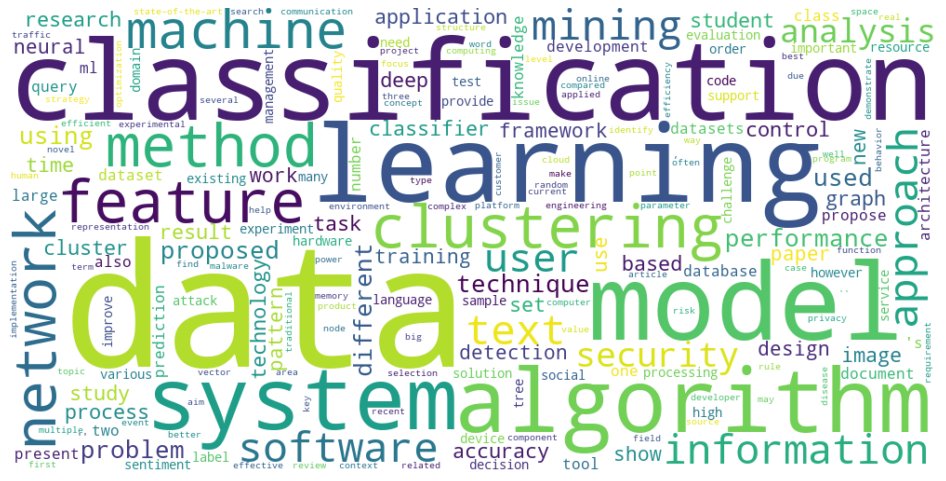

In [68]:
word_cloud(list_values_iad,'') # 'TOTAL BAG POST IAD'

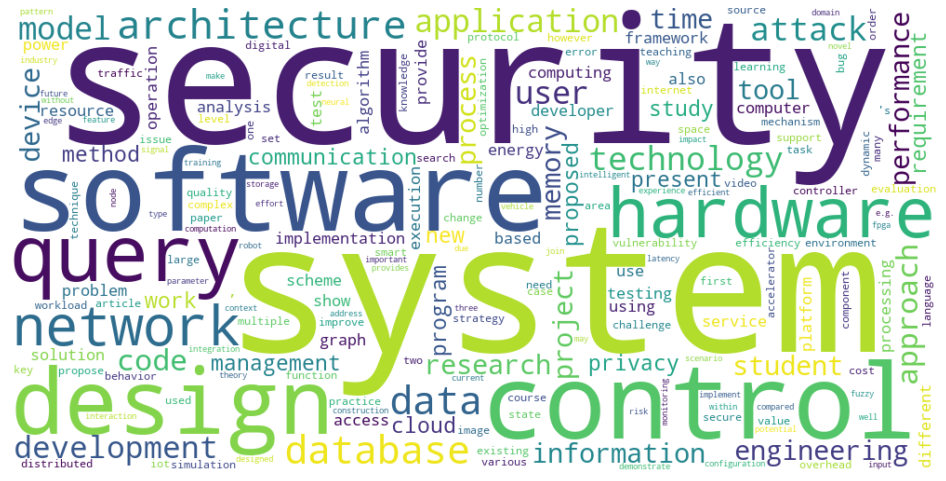

In [69]:
word_cloud(list_values_no_iad,'') # 'TOTAL BAG POST NO IAD'

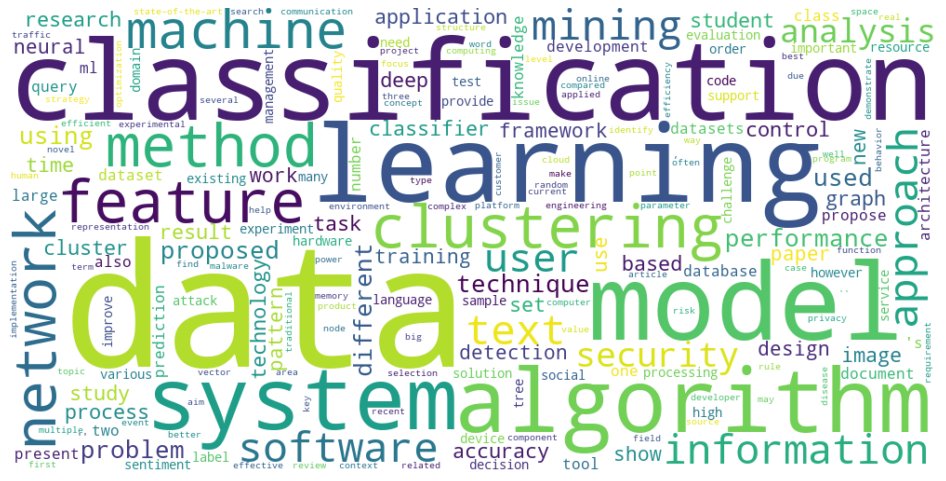

In [70]:
word_cloud(list_values,'') # 'TOTAL BAG POST'

#### Кластеризация

In [71]:
labels = np.array([0]*1500+[1]*1500)

In [72]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(array_keywords_weight_items)

KMeans(n_clusters=2)

In [73]:
kmeans_labels = kmeans.predict(array_keywords_weight_items)

In [74]:
sum(kmeans_labels[:1500]==labels[:1500]), sum(kmeans_labels[1500:]==labels[1500:]), sum(kmeans_labels!=labels) # iad, no_iad, error

(1115, 1368, 517)

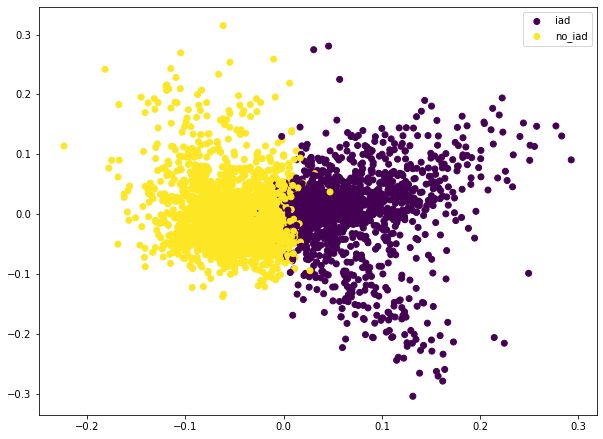

In [79]:
fig = plt.figure(figsize=(10,7.5))
plt.scatter(pca_keywords2[:1500,0],pca_keywords2[:1500,1],label='iad',c=kmeans_labels[:1500])
plt.scatter(pca_keywords2[1500:,0],pca_keywords2[1500:,1],label='no_iad',c=kmeans_labels[1500:])
plt.legend()

#### Классификация

In [347]:
gaussiannb=GaussianNB()

In [ ]:
i=0
res=[]
res_mean=[]
num_words=[]
while(i<=15): # 100
    bag_words=cut_low_freq_words(bag_words_begin,number=i)
    list_keywords=make_list_keywords(bag_words,results)
    print('hi')
    list_keywords_weight=tfc(list_keywords)
    list_keywords_weight_items=make_list_keywords_weight_items(list_keywords_weight)
    array_keywords_weight_items=np.array(list_keywords_weight_items)
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    r=cross_val_score(gaussiannb, array_keywords_weight_items, labels, cv=strat_k_fold)
    res.append(r)
    res_mean.append(np.mean(r))
    num_words.append(len(bag_words))
    i+=1

In [349]:
#with open('res_k_folds.pkl','wb') as pr:
    #pickle.dump(res,pr)

In [350]:
#with open('num_words.pkl','wb') as pr:
    #pickle.dump(num_words,pr)

In [351]:
with open('res_k_folds.pkl','rb') as ar:
    res = pickle.load(ar)
with open('num_words.pkl','rb') as ar:
    num_words = pickle.load(ar)
res_mean = []
for r in res:
    res_mean.append(np.mean(r))

In [352]:
res_mean[-1]

0.8447058823529412

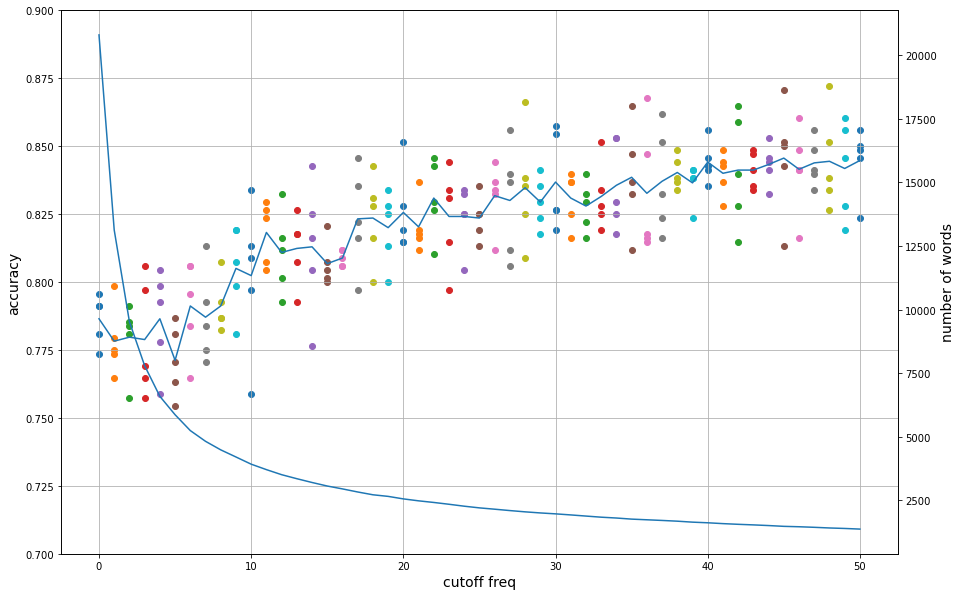

In [353]:
import matplotlib.pyplot as plt 
min_k = 0 # 0
max_k = len(num_words) # 101
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax2 = ax.twinx()
for i in range(min_k,max_k):
    ax.scatter([i]*len(res[0]),res[i])
ax.plot(range(min_k,max_k),res_mean[min_k:max_k])
ax2.plot(range(min_k,max_k),num_words[min_k:max_k])
ax.set_ylabel("accuracy",fontsize=14)
ax2.set_ylabel("number of words",fontsize=14)
ax.set_ylim((0.7,0.9))
#ax.set_xlim(xmax=100)
ax.grid(True)
#plt.title("name", fontsize=20,color='black')
ax.set_xlabel('cutoff freq', fontsize=14)
plt.show()

In [131]:
num_words[11]

3708

##### Поиск параметров

In [80]:
bag_words=cut_low_freq_words(bag_words_begin,number=11) ###!!! MB ERROR NUMBER # old 11 and 16
list_keywords=make_list_keywords(bag_words,results)
list_keywords_weight=tfc(list_keywords)
list_keywords_weight_items=make_list_keywords_weight_items(list_keywords_weight)
array_keywords_weight_items=np.array(list_keywords_weight_items)

In [81]:
labels = np.array([0]*1500+[1]*1500)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(array_keywords_weight_items, labels, test_size=0.30, random_state=0)

###### Decision Tree

In [102]:
dtc_gs = GridSearchCV(DecisionTreeClassifier(),
                         {'criterion': ['gini','entropy'],
                          'max_depth': list(range(100,201,20)),
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10]},
                          n_jobs=6,cv=5,error_score='raise',return_train_score=True)

In [ ]:
dtc_gs.fit(X_train, y_train)

In [85]:
dtc_gs.best_params_ # {'criterion': 'gini', 'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 2}

{'criterion': 'gini',
 'max_depth': 140,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [116]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=140, min_samples_leaf=1, min_samples_split=2)

In [117]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=140)

In [118]:
accuracy_score(dtc.predict(X_test),y_test)

0.8244444444444444

In [119]:
cross_val_score(dtc, array_keywords_weight_items, labels, cv=5)

array([0.83666667, 0.85      , 0.86166667, 0.84666667, 0.84666667])

###### Random Forest

In [179]:
rfc_gs = GridSearchCV(RandomForestClassifier(bootstrap=True, random_state=0),
                         {'n_estimators': list(range(105,116,5)),
                          'max_depth': list(range(35,46,5)),
                          'max_features': list(range(105,116,5))},
                          n_jobs=-1,cv=5,error_score='raise',return_train_score=True)

In [180]:
rfc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [35, 40, 45],
                         'max_features': [105, 110, 115],
                         'n_estimators': [105, 110, 115]},
             return_train_score=True)

In [83]:
rfc = RandomForestClassifier(n_estimators=115,bootstrap=False,max_depth=45, max_features=110, min_samples_leaf=3,min_samples_split=11, random_state=456)

In [84]:
# n_estimators=115 #
# max_depth=45 #
# max_features=110 #
# min_samples_leaf=3 #
# min_samples_split=11 #

In [85]:
# 0.930392 - 700, 0.932352 - 800, 0.9333333 - 900, 0.9352941176470588 - 1000, 0.9343137254901961 - 1100
# 0.9343137254901961 - 1200, 0.9333333 - 1500

In [86]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=45, max_features=110,
                       min_samples_leaf=3, min_samples_split=11,
                       n_estimators=115, random_state=456)

In [87]:
accuracy_score(rfc.predict(X_test),y_test)

0.9166666666666666

In [88]:
cross_val_score(rfc, array_keywords_weight_items, labels, cv=5)

array([0.91833333, 0.92166667, 0.92      , 0.90333333, 0.90333333])

In [89]:
_.mean()

0.9133333333333333

In [90]:
cv_rfc, scores_rfc = classifier_scores(RandomForestClassifier(n_estimators=115,bootstrap=False,max_depth=45, max_features=110, min_samples_leaf=3,min_samples_split=11, random_state=456),X_train,y_train)

In [91]:
print('accuracy',scores_rfc['test_accuracy'], scores_rfc['test_accuracy'].mean())
print('precision_binary_pos',scores_rfc['test_precision_binary_pos'], scores_rfc['test_precision_binary_pos'].mean())
print('recall_binary_pos',scores_rfc['test_recall_binary_pos'], scores_rfc['test_recall_binary_pos'].mean())
print('f1_binary_pos',scores_rfc['test_f1_binary_pos'], scores_rfc['test_f1_binary_pos'].mean())

accuracy [0.91904762 0.88809524 0.90714286 0.93333333 0.89761905] 0.909047619047619
precision_binary_pos [0.89201878 0.84684685 0.88942308 0.89908257 0.88405797] 0.8822858485868957
recall_binary_pos [0.94527363 0.93532338 0.92039801 0.97029703 0.90594059] 0.9354465297275997
f1_binary_pos [0.94527363 0.93532338 0.92039801 0.97029703 0.90594059] 0.9354465297275997


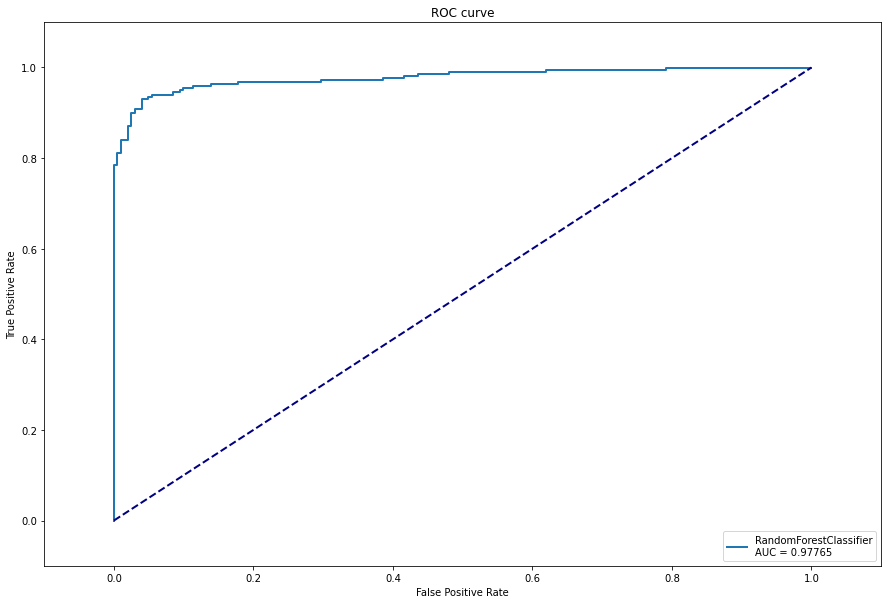

In [92]:
classifier_plot([cv_rfc],[scores_rfc],X_train,y_train)

In [93]:
best_rfc=scores_rfc['estimator'][scores_rfc['test_f1_binary_pos'].argmax()]

In [138]:
pd.DataFrame(best_rfc.predict_proba(array_keywords_weight_items)).sort_values(0,ascending=False).head(10)

,0,1
1012,0.993188,0.006812
777,0.993188,0.006812
1448,0.993188,0.006812
368,0.992101,0.007899
267,0.992101,0.007899
261,0.992101,0.007899
996,0.990683,0.009317
1512,0.990683,0.009317
219,0.990683,0.009317
1659,0.987502,0.012498


In [132]:
results[1407]

{'title': 'Mining Free-Text Medical Notes for Suicide Risk Assessment',
 'link': 'https://dl.acm.org/doi/10.1145/3200947.3201020',
 'authors': ['Marios Adamou',
  'Grigoris Antoniou',
  'Elissavet Greasidou',
  'Vincenzo Lagani',
  'Paulos Charonyktakis',
  'Ioannis Tsamardinos'],
 'date': 'July 2018',
 'abstract': 'Suicide has been considered as an important public health issue for a very long time, and is one of the main causes of death worldwide. Despite suicide prevention strategies being applied, the rate of suicide has not changed substantially over the past decades. Advances in machine learning make it possible to attempt to predict suicide based on the analysis of relevant data to inform clinical practice. This paper reports on findings from the analysis of data of patients who died by suicide in the period 2013-2016 and made use of both structured data and free-text medical notes. We focus on examining various text-mining approaches to support risk assessment. The results show

In [94]:
print(classification_report(y_test,best_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       493
           1       0.92      0.89      0.90       407

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



In [95]:
y_pred_rfc=best_rfc.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred_rfc))
print('precision_binary_pos',precision_score(y_test,y_pred_rfc,pos_label=0))
print('recall_binary_pos',recall_score(y_test,y_pred_rfc,pos_label=0))
print('f1_binary_pos',f1_score(y_test,y_pred_rfc,pos_label=0))

accuracy 0.9144444444444444
precision_binary_pos 0.9110671936758893
recall_binary_pos 0.9350912778904665
f1_binary_pos 0.922922922922923


In [ ]:
# 300, 1178, 777, 323, 108

###### Logistic Regression

In [ ]:
log_reg_gs_1 = GridSearchCV(LogisticRegression(),
                          {'penalty':['l2'],
                           'C':np.logspace(-3,3,7),
                           'solver':['newton-cg']}, # ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                           n_jobs=-1,cv=5, error_score='raise')

In [355]:
log_reg_gs_2 = GridSearchCV(LogisticRegression(),
                          {'penalty':['l1','l2'],
                           'C':np.logspace(-3,3,7),
                           'solver':['liblinear','saga']},
                           n_jobs=-1,cv=5, error_score='raise')

In [ ]:
log_reg_gs_1.fit(X_train, y_train);

In [ ]:
log_reg_gs_2.fit(X_train, y_train);

In [ ]:
log_reg_gs_1.best_params_ # {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
log_reg_gs_2.best_params_ # {'C': 10.0, 'penalty': 'l1', 'solver': 'saga'}

In [96]:
log_reg = LogisticRegression(penalty='l2',C=10,solver='newton-cg') # best
# log_reg = LogisticRegression(penalty='l1',C=10,solver='saga',max_iter=300)

In [97]:
log_reg.fit(X_train,y_train)

LogisticRegression(C=10, solver='newton-cg')

In [98]:
accuracy_score(log_reg.predict(X_test),y_test) # l2 newton-cg

0.91

In [99]:
print(classification_report(y_test,log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       493
           1       0.88      0.93      0.90       407

    accuracy                           0.91       900
   macro avg       0.91      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



In [100]:
cross_val_score(log_reg, array_keywords_weight_items, labels, cv=5)

array([0.89666667, 0.93      , 0.91333333, 0.89666667, 0.885     ])

In [101]:
_.mean()

0.9043333333333333

In [102]:
cv_log_reg, scores_log_reg = classifier_scores(LogisticRegression(penalty='l2',C=10,solver='newton-cg'),X_train,y_train)

In [103]:
print('accuracy',scores_log_reg['test_accuracy'], scores_log_reg['test_accuracy'].mean())
print('precision_binary_pos',scores_log_reg['test_precision_binary_pos'], scores_log_reg['test_precision_binary_pos'].mean())
print('recall_binary_pos',scores_log_reg['test_recall_binary_pos'], scores_log_reg['test_recall_binary_pos'].mean())
print('f1_binary_pos',scores_log_reg['test_f1_binary_pos'], scores_log_reg['test_f1_binary_pos'].mean())

accuracy [0.86904762 0.89761905 0.89047619 0.92380952 0.88809524] 0.8938095238095236
precision_binary_pos [0.87628866 0.89108911 0.91005291 0.9009434  0.9144385 ] 0.8985625155315654
recall_binary_pos [0.84577114 0.89552239 0.85572139 0.94554455 0.84653465] 0.8778188266587852
f1_binary_pos [0.84577114 0.89552239 0.85572139 0.94554455 0.84653465] 0.8778188266587852


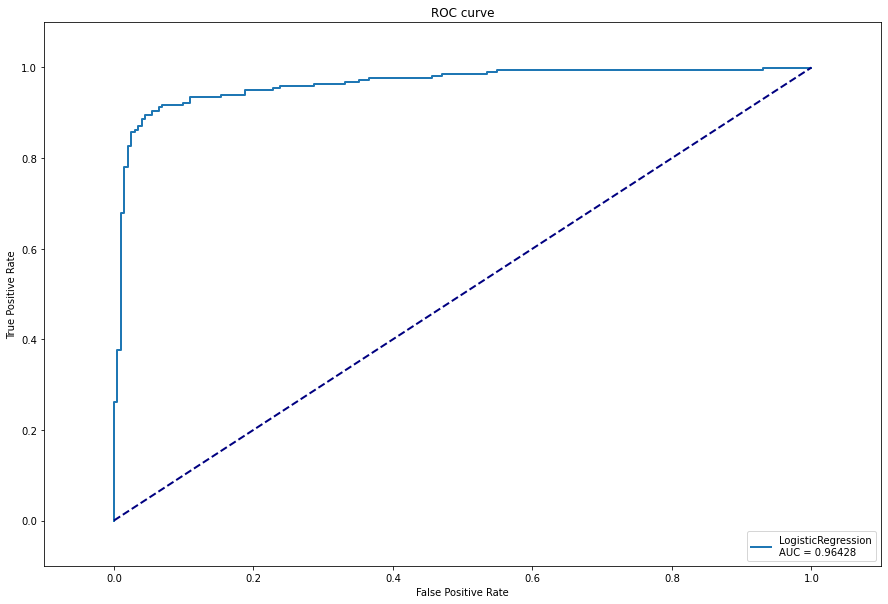

In [104]:
classifier_plot([cv_log_reg],[scores_log_reg],X_train,y_train)

In [105]:
best_log_reg=scores_log_reg['estimator'][scores_log_reg['test_f1_binary_pos'].argmax()]

In [106]:
print(classification_report(y_test,best_log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       493
           1       0.87      0.93      0.90       407

    accuracy                           0.91       900
   macro avg       0.90      0.91      0.91       900
weighted avg       0.91      0.91      0.91       900



In [107]:
y_pred_log_reg=best_log_reg.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred_log_reg))
print('precision_binary_pos',precision_score(y_test,y_pred_log_reg,pos_label=0))
print('recall_binary_pos',recall_score(y_test,y_pred_log_reg,pos_label=0))
print('f1_binary_pos',f1_score(y_test,y_pred_log_reg,pos_label=0))

accuracy 0.9055555555555556
precision_binary_pos 0.9358974358974359
recall_binary_pos 0.8884381338742393
f1_binary_pos 0.9115504682622269


###### K-Nearest Neighbors

In [ ]:
KNeighborsClassifier()

In [306]:
knn_gs = GridSearchCV(KNeighborsClassifier(n_neighbors=30),
                         {'n_neighbors':list(range(195,205,1)),
                          'weights':['distance'],
                          'metric':['cosine']},
                          n_jobs=-1,cv=5,error_score='raise')

In [307]:
knn_gs.fit(X_train,y_train);

In [308]:
knn_gs.best_params_ # {'metric': 'cosine', 'n_neighbors': 201, 'weights': 'distance'}

{'metric': 'cosine', 'n_neighbors': 201, 'weights': 'distance'}

In [108]:
knn = KNeighborsClassifier(n_neighbors=201, weights='distance', metric='cosine')

In [109]:
knn.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=201, weights='distance')

In [110]:
accuracy_score(knn.predict(X_test),y_test)

0.9011111111111111

In [111]:
print(classification_report(y_test,knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       493
           1       0.90      0.88      0.89       407

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



In [112]:
cross_val_score(knn, array_keywords_weight_items, labels, cv=5)

array([0.885     , 0.91666667, 0.88      , 0.88833333, 0.85833333])

In [113]:
cv_knn, scores_knn = classifier_scores(KNeighborsClassifier(n_neighbors=201, weights='distance', metric='cosine'),X_train,y_train)

In [114]:
print('accuracy',scores_knn['test_accuracy'], scores_knn['test_accuracy'].mean())
print('precision_binary_pos',scores_knn['test_precision_binary_pos'], scores_knn['test_precision_binary_pos'].mean())
print('recall_binary_pos',scores_knn['test_recall_binary_pos'], scores_knn['test_recall_binary_pos'].mean())
print('f1_binary_pos',scores_knn['test_f1_binary_pos'], scores_knn['test_f1_binary_pos'].mean())

accuracy [0.85714286 0.87380952 0.87380952 0.89761905 0.87857143] 0.8761904761904763
precision_binary_pos [0.82191781 0.81896552 0.84579439 0.85022026 0.87192118] 0.8417638329134224
recall_binary_pos [0.89552239 0.94527363 0.90049751 0.95544554 0.87623762] 0.914595340131028
f1_binary_pos [0.89552239 0.94527363 0.90049751 0.95544554 0.87623762] 0.914595340131028


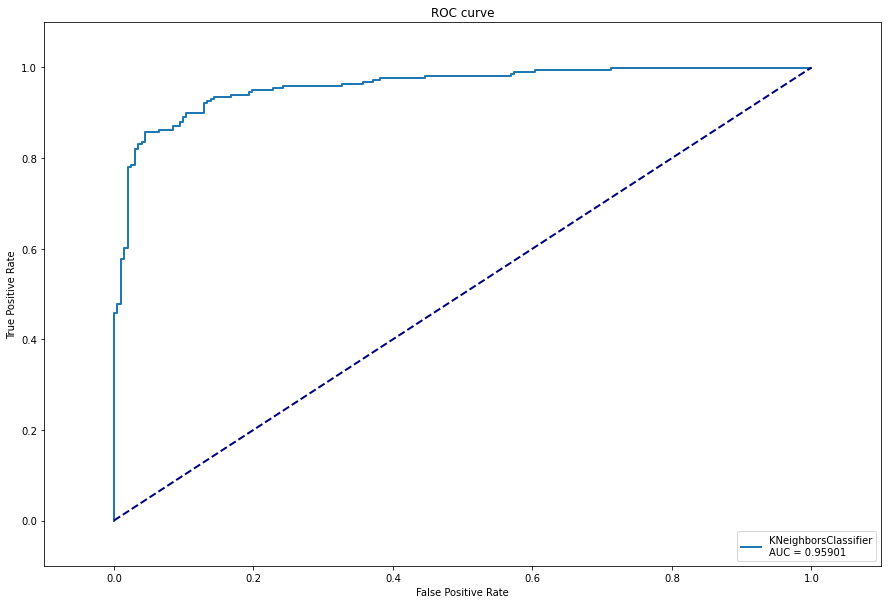

In [115]:
classifier_plot([cv_knn],[scores_knn],X_train,y_train)

In [116]:
best_knn=scores_knn['estimator'][scores_log_reg['test_f1_binary_pos'].argmax()]

In [117]:
print(classification_report(y_test,best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       493
           1       0.90      0.87      0.89       407

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



In [118]:
y_pred_knn=best_knn.predict(X_test)
print('accuracy',accuracy_score(y_test,y_pred_knn))
print('precision_binary_pos',precision_score(y_test,y_pred_knn,pos_label=0))
print('recall_binary_pos',recall_score(y_test,y_pred_knn,pos_label=0))
print('f1_binary_pos',f1_score(y_test,y_pred_knn,pos_label=0))

accuracy 0.8977777777777778
precision_binary_pos 0.8986083499005965
recall_binary_pos 0.9168356997971603
f1_binary_pos 0.9076305220883534


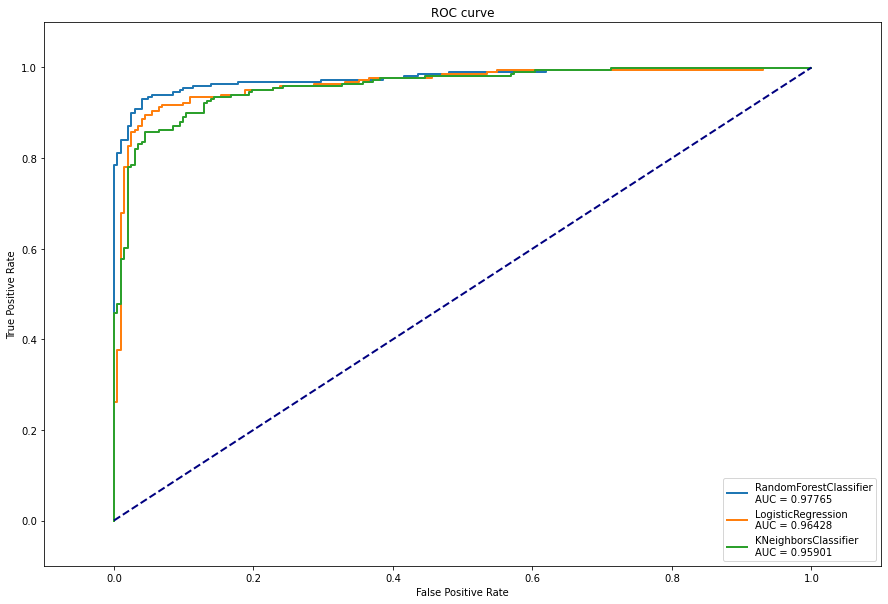

In [119]:
classifier_plot([cv_rfc, cv_log_reg, cv_knn],[scores_rfc, scores_log_reg, scores_knn],X_train,y_train)